[![View On GitHub](https://img.shields.io/badge/View_in_Github-grey?logo=github)](https://github.com/Qrlew/docs/blob/main/tutorials/getting_started.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qrlew/docs/blob/main/tutorials/getting_started.ipynb)
# Getting Started

[Qrlew](https://qrlew.github.io/) is an [open source library](https://github.com/Qrlew) that can turn SQL queries into their [differentially private (DP)](https://en.wikipedia.org/wiki/Differential_privacy) equivalent.
* It takes SQL – the universal language of small and big data analytics – as input, so there is no new language or API to learn.
* It returns DP SQL queries that can be executed at scale on any SQL datastore.
* The only required extra inputs are the *privacy unit* specification and privacy budget $(\varepsilon, \delta)$.

With [Qrlew](https://qrlew.github.io/) a *data owner* can receive SQL queries from an untrusted *data analyst*, turn them into DP equivalent, execute them and safely return the result to the *data analyst*.

In this quick intro, we will setup a database, load a few demo tables.
Then we will define the *privacy unit* and run simple DP SQL queries to show how [Qrlew](https://qrlew.github.io/) works on various kind of queries with Joins, Subqueries or Common Table Expressions.

We will also explore more advanced features:
* The support of several SQL dialects: PostgreSQL (default), MSSQL or BigQuery.
* The possibility to provide hints – data ranges, finite set of values or unicity constraints – to qrlew to improve the usefulness of the results.
* Privacy accounting compatibility with Google's popular Differential Privacy accounting: [dp_accounting](https://github.com/google/differential-privacy/tree/main/python/dp_accounting).
* The use of Synthetic Data to further improve the quality of the results.

## Get access to a database

Let's start by installing a local PostgreSQL database.

Qrlew currently supports the following SQL dialects:
- [PostgreSQL](https://www.postgresql.org/),
- [BigQuery](https://cloud.google.com/bigquery?hl=en),
- [Synapse/MSSQL](https://azure.microsoft.com/en-us/products/synapse-analytics/).

In [1]:
%%capture
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'password'"
!pip install psycopg2

## Install [Qrlew](https://qrlew.github.io/) python bindings: `pyqrlew`

`pyqrlew` is distributed on [PyPI](https://pypi.org/project/pyqrlew/) and simply installed with `pip install`.

If no binary is available for your platform, you will need a [Rust compiler](https://rustup.rs/) to install the library from sources.

Binaries are [available](https://github.com/Qrlew/pyqrlew/blob/main/.github/workflows/ci.yml) for Linux, MacOS, Windows and major architectures including x86, arm or Apple chips.

In [2]:
%%capture
!pip install pyqrlew

## Load a few tables

Let's load a `pyqrlew` demo dataset: [IMDb](https://relational.fit.cvut.cz/dataset/IMDb), composed of several related tables.

In [3]:
from pyqrlew.io import PostgreSQL

database = PostgreSQL('postgres', 'postgres', 'password', 5432)
database.load_imdb()
engine = database.engine()

We can display a short extract of each table.

In [4]:
from IPython.display import display, Markdown
import pandas as pd

for table in ['actors', 'directors', 'directors_genres', 'movies', 'movies_directors', 'movies_genres', 'roles']:
  display(Markdown(f'## {table}'))
  display(pd.read_sql(f'SELECT * FROM imdb_ijs.{table} LIMIT 3', engine))

## actors

,id,first_name,last_name,gender
0,2,Michael,'babeepower' Viera,M
1,3,Eloy,'Chincheta',M
2,4,Dieguito,'El Cigala',M


## directors

,id,first_name,last_name
0,1,Todd,1
1,2,Les,12 Poissons
2,3,Lejaren,a'Hiller


## directors_genres

,director_id,genre,prob
0,2,Short,1.0
1,3,Drama,1.0
2,5,Documentary,1.0


## movies

,id,name,year,rank
0,0,#28,2002,NaN
1,1,"#7 Train: An Immigrant Journey, The",2000,NaN
2,2,$,1971,6.4


## movies_directors

,director_id,movie_id
0,1,378879
1,2,281325
2,3,30621


## movies_genres

,movie_id,genre
0,1,Documentary
1,1,Short
2,2,Comedy


## roles

,actor_id,movie_id,role
0,2,280088,Stevie
1,2,396232,Various/lyricist
2,3,376687,Gitano 1


## Connect to the database and create a `pyqrlew.Dataset`

To use [Qrlew](https://qrlew.github.io/) the SQL tables have to be collected into a `Dataset` object that will enrich the tables with metadata such as privacy unit or value ranges definitions.

[Qrlew](https://qrlew.github.io/) basic constructs are [relations](https://en.wikipedia.org/wiki/Relation_(database)): abstract representation of SQL queries.

Tables are the most basic [relations](https://en.wikipedia.org/wiki/Relation_(database)) in qrlew.

In [5]:
from pyqrlew import Dataset

source_dataset = Dataset.from_database('imdb', engine, 'imdb_ijs')

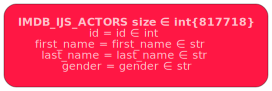

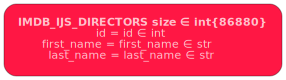

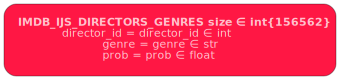

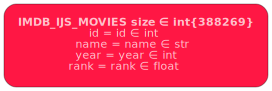

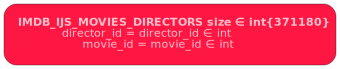

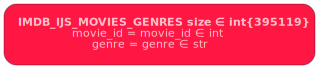

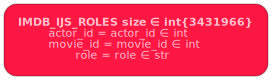

In [6]:
from graphviz import Source

for path, relation in source_dataset.relations():
  display(Source(relation.dot()))

## Declare value ranges and unique constraints

If ranges are known for some numeric columns, it is possible to define them with the following syntax `new_dataset = dataset.<schema>.<table>.<column>.with_range(min, max)`.

Note that inferring those ranges from the data may reveal private information if not done right.

In [7]:
bounded_dataset = source_dataset.imdb_ijs.movies.rank.with_range(0, 20)

If some columns have known possible values, they can also be declared.

Here again, simple inference from the data would be unsafe.

In [8]:
bounded_dataset = bounded_dataset.imdb_ijs.actors.gender.with_possible_values(['M', 'F'])

Some column are known to have a distincts values (although not specified in the DB schema).

In [9]:
dataset = (bounded_dataset
  .imdb_ijs.actors.id.with_unique_constraint()
  .imdb_ijs.directors.id.with_unique_constraint()
  .imdb_ijs.movies.id.with_unique_constraint())

The new dataset enriched with new metadata can be visualized.

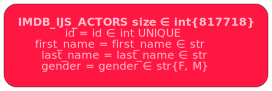

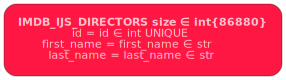

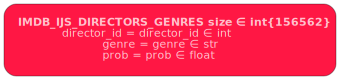

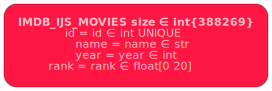

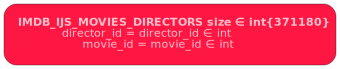

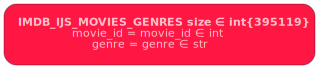

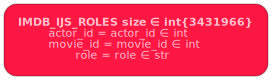

In [10]:
for path, relation in dataset.relations():
  display(Source(relation.dot()))

## Define the privacy unit

To protect the privacy of individuals in a dataset, we need to define what is to be protected in the dataset.

Let's say we want to protect the privacy of actors and directors.
For the tables `actors` and `directors` the column `id` will directly define the *privacy unit* (i.e. entity to protect).

But the tables `directors_genres`, `movies_directors` and `roles` also define directors and actors, because they refer to them through `director_id` and `actor_id`.

In [11]:
# Privacy unit definition
privacy_unit = [
    # The column `id` directly defines the privacy unit
    ("actors", [], "id"),
    ("directors", [], "id"),
    # The column `director_id` refers to the column `id` of table `directors`, the `id` of which defines the privacy unit
    ("directors_genres", [("director_id", "directors", "id")], "id"),
    ("movies_directors", [("director_id", "directors", "id")], "id"),
    # The column `actor_id` refers to the column `id` of table `actors`, the `id` of which defines the privacy unit
    ("roles", [("actor_id", "actors", "id")], "id"),
]
# Privacy paramers
budget = {"epsilon": 1.0, "delta": 1e-3}

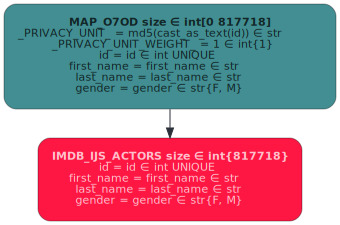

In [12]:
# Privacy unit is propagted accross the relation
pup_actors = dataset.imdb_ijs.actors.relation().rewrite_as_privacy_unit_preserving(
    dataset,
    privacy_unit,
    budget,
)
display(Source(pup_actors.relation().dot()))

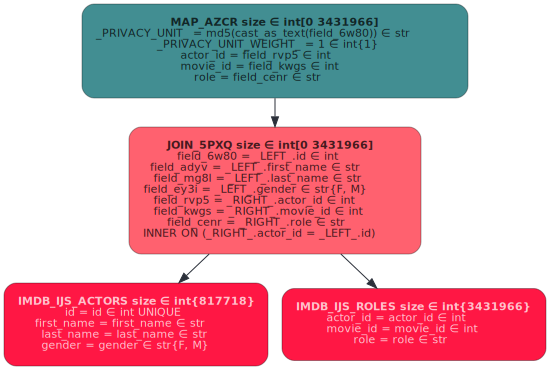

In [13]:
# Privacy unit is propagted accross the relation
pup_roles = dataset.imdb_ijs.roles.relation().rewrite_as_privacy_unit_preserving(
    dataset,
    privacy_unit,
    budget,
)
display(Source(pup_roles.relation().dot()))

## Convert a simple aggregation query into a DP equivalent

In [14]:
# We create a basic aggregation relation
query = "SELECT gender, COUNT(*) FROM imdb_ijs.actors GROUP BY gender"
relation = dataset.relation(query)
# The relation is turned into a DP equivalent
relation_with_dp_event = relation.rewrite_with_differential_privacy(
    dataset,
    privacy_unit,
    budget,
)
# Rewritten relation
dp_relation = relation_with_dp_event.relation()
# Privacy loss
dpe = relation_with_dp_event.dp_event()
print(dpe)

DpEvent(Gaussian { noise_multiplier: 3.776479532659047 })


`dp_events` are compatible with Google's `dp_accounting`

In [15]:
%%capture
!pip install dp_accounting==0.4.1

In [16]:
# Google's dp_accounting
from dp_accounting import DpEvent
print(DpEvent.from_named_tuple(dpe.to_named_tuple()))

/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


GaussianDpEvent(noise_multiplier=3.776479532659047)


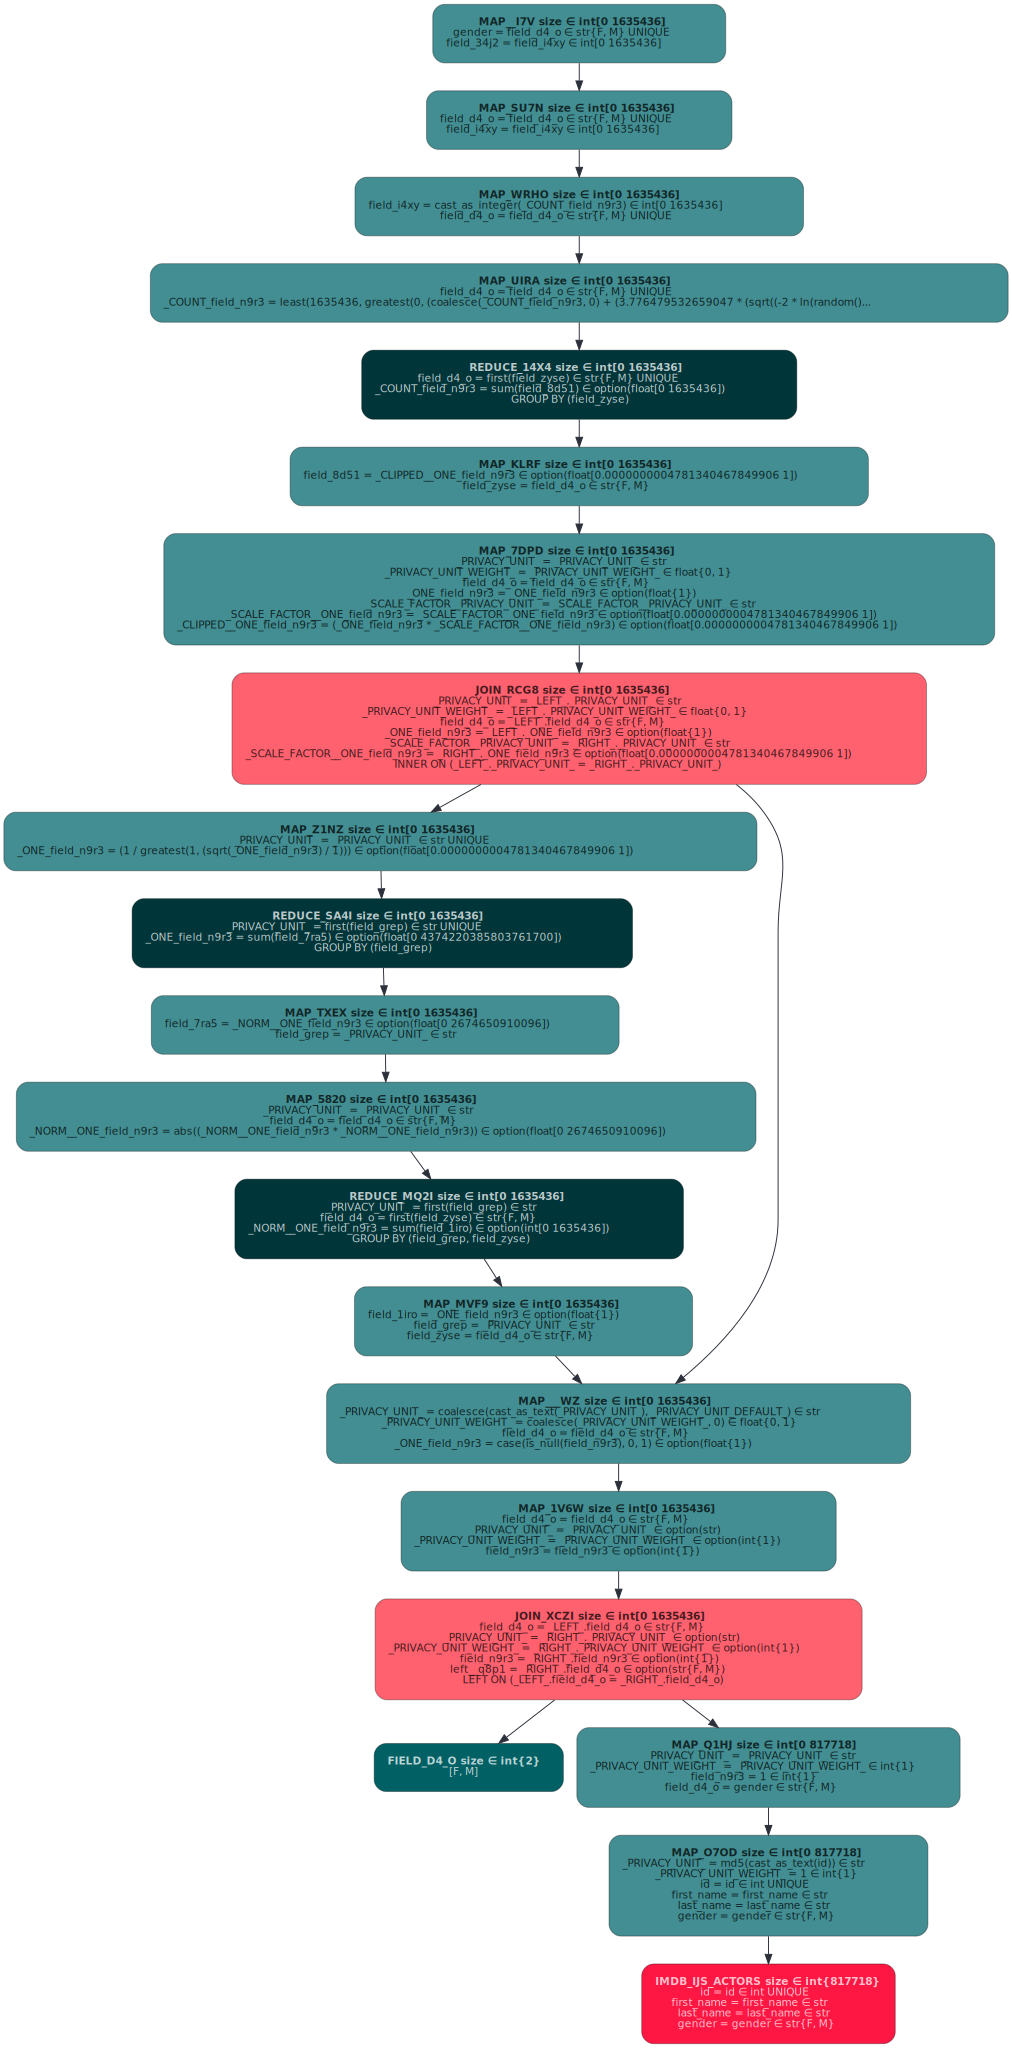

In [17]:
display(Source(dp_relation.dot()))

In [18]:
dp_query = dp_relation.to_query()
display(dp_query)

"WITH field_d4_o (field_d4_o) AS (SELECT * FROM (VALUES ('F'), ('M')) AS field_d4_o (field_d4_o)), map_o7od (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, id, first_name, last_name, gender) AS (SELECT MD5(CAST(id AS TEXT)) AS _PRIVACY_UNIT_, 1 AS _PRIVACY_UNIT_WEIGHT_, id AS id, first_name AS first_name, last_name AS last_name, gender AS gender FROM imdb_ijs.actors), map_q1hj (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, field_n9r3, field_d4_o) AS (SELECT _PRIVACY_UNIT_ AS _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_ AS _PRIVACY_UNIT_WEIGHT_, 1 AS field_n9r3, gender AS field_d4_o FROM map_o7od), join_xczi (field_d4_o, _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, field_n9r3, left__q8p1) AS (SELECT * FROM field_d4_o AS _LEFT_ LEFT JOIN map_q1hj AS _RIGHT_ ON (_LEFT_.field_d4_o) = (_RIGHT_.field_d4_o)), map_1v6w (field_d4_o, _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, field_n9r3) AS (SELECT field_d4_o AS field_d4_o, _PRIVACY_UNIT_ AS _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_ AS _PRIVACY_UNIT_WEIGHT_, field_n9r3 AS field_n9

In [19]:
import pandas as pd

true_res = pd.read_sql(query, database.engine())
dp_res = pd.read_sql(dp_query, database.engine())

display(Markdown(f'## Result'))
display(true_res)

display(Markdown(f'## DP Result'))
display(dp_res)

## Result

,gender,count
0,F,304412
1,M,513306


## DP Result

,gender,field_34j2
0,M,513300
1,F,304413
